 # Augmentation in Deeplearning Model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import random
import time
import re
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from ipywidgets import interact
from tqdm import tqdm_notebook
from google.colab import drive
from scipy import stats

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 1. Load Data

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/DSML')

In [ ]:
df = pd.read_csv('LUADLUSC_float32.tsv', delimiter='\t', index_col=0).astype('float32')

In [ ]:
df_copy = df.copy()

# 2.  EDA

## 2-1. Data Introduction

In [ ]:
df_copy

,ENTREZ:100134869|HGNC:37440|UBE2Q2P2,ENTREZ:10357|HGNC:4993|HMGB1P1,ENTREZ:26823|HGNC:10109|RNU12-2P,ENTREZ:280660|HGNC:19655|SSX9P,ENTREZ:340602|HGNC:33738|EZHIP,ENTREZ:388795|HGNC:34532|EFCAB8,ENTREZ:390284|HGNC:33181|SRP14P1,ENTREZ:391714|HGNC:32686|TRIM75P,ENTREZ:404770|HGNC:31411|SPATA31B1P,ENTREZ:441362|HGNC:32243|REXO1L6P,ENTREZ:442388|HGNC:35413|SDR16C6P,ENTREZ:653553|HGNC:5251|HSPB1P1,ENTREZ:728788|HGNC:32319|ANKRD20A20P,ENTREZ:8225|HGNC:30189|GTPBP6,ENTREZ:90288|HGNC:28061|EFCAB12,ENTREZ:1|HGNC:5|A1BG,ENTREZ:29974|HGNC:24086|A1CF,ENTREZ:54715|HGNC:18222|RBFOX1,ENTREZ:87769|HGNC:25100|GGACT,ENTREZ:144568|HGNC:23336|A2ML1,ENTREZ:2|HGNC:7|A2M,ENTREZ:53947|HGNC:18149|A4GALT,ENTREZ:51146|HGNC:17968|A4GNT,ENTREZ:404744|HGNC:22128|NPSR1-AS1,ENTREZ:8086|HGNC:13666|AAAS,ENTREZ:729522|HGNC:18226|AACSP1,ENTREZ:65985|HGNC:21298|AACS,ENTREZ:344752|HGNC:24427|AADACL2,ENTREZ:126767|HGNC:32037|AADACL3,ENTREZ:343066|HGNC:32038|AADACL4,ENTREZ:13|HGNC:17|AADAC,ENTREZ:51166|HGNC:17929|AADAT,ENTREZ:79719|HGNC:25662|AAGAB,ENTREZ:22848|HGNC:19679|AAK1,ENTREZ:14|HGNC:18|AAMP,ENTREZ:15|HGNC:19|AANAT,ENTREZ:57505|HGNC:21022|AARS2,ENTREZ:80755|HGNC:28417|AARSD1,ENTREZ:16|HGNC:20|AARS1,ENTREZ:60496|HGNC:14235|AASDHPPT,...,ENTREZ:9406|HGNC:13058|ZRANB2,ENTREZ:84083|HGNC:25249|ZRANB3,ENTREZ:8233|HGNC:23019|ZRSR2,ENTREZ:84891|HGNC:12997|ZSCAN10,ENTREZ:221584|HGNC:13850|ZSCAN12P1,ENTREZ:9753|HGNC:13172|ZSCAN12,ENTREZ:80345|HGNC:20813|ZSCAN16,ENTREZ:65982|HGNC:21037|ZSCAN18,ENTREZ:284312|HGNC:23712|ZSCAN1,ENTREZ:7579|HGNC:13093|ZSCAN20,ENTREZ:7589|HGNC:13104|ZSCAN21,ENTREZ:342945|HGNC:4929|ZSCAN22,ENTREZ:222696|HGNC:21193|ZSCAN23,ENTREZ:146050|HGNC:26673|ZSCAN29,ENTREZ:54993|HGNC:20994|ZSCAN2,ENTREZ:201516|HGNC:23709|ZSCAN4,ENTREZ:79149|HGNC:23710|ZSCAN5A,ENTREZ:342933|HGNC:34246|ZSCAN5B,ENTREZ:90204|HGNC:16155|ZSWIM1,ENTREZ:151112|HGNC:30990|ZSWIM2,ENTREZ:140831|HGNC:16157|ZSWIM3,ENTREZ:65249|HGNC:25704|ZSWIM4,ENTREZ:57643|HGNC:29299|ZSWIM5,ENTREZ:57688|HGNC:29316|ZSWIM6,ENTREZ:125150|HGNC:26993|ZSWIM7,ENTREZ:221302|HGNC:21224|ZUP1,ENTREZ:9183|HGNC:13194|ZW10,ENTREZ:55055|HGNC:25468|ZWILCH,ENTREZ:11130|HGNC:13195|ZWINT,ENTREZ:7789|HGNC:13198|ZXDA,ENTREZ:158586|HGNC:13199|ZXDB,ENTREZ:79364|HGNC:28160|ZXDC,ENTREZ:440590|HGNC:32058|ZYG11A,ENTREZ:79699|HGNC:25820|ZYG11B,ENTREZ:7791|HGNC:13200|ZYX,ENTREZ:23140|HGNC:29027|ZZEF1,ENTREZ:26009|HGNC:24523|ZZZ3,ENTREZ:387590|HGNC:43648|TPTEP1,ENTREZ:389932|HGNC:44680|AKR1C6P,"target,LUAD:0,LUSC:1"
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCGA-05-4244-01A-01R-1107-07,11.282000,49.599400,1.0472,0.0000,0.0000,5.236100,5.5851,0.0000,0.0,0.0,0.0,546.644592,1.0472,307.182098,33.161701,26.030199,0.000,1.7454,135.502197,0.349100,9844.786133,130.901505,1.0472,0.0000,651.016724,0.6981,803.560486,0.698100,0.0,0.0000,3.490700,53.058701,988.218872,1038.135986,1915.350342,0.0000,516.928223,472.292511,3054.716797,465.660187,...,1640.373535,24.784000,148.354996,0.3491,22.762899,73.653900,193.734207,125.665398,1.745400,83.776901,176.535507,145.562393,4.887000,400.034912,154.987305,1.7454,29.321899,0.3491,192.337906,0.3491,130.203293,850.335999,162.666901,842.656372,220.263504,152.194794,179.771393,221.164200,517.671692,39.793999,292.521210,959.245972,0.698100,1088.053101,2837.944092,871.280212,575.268311,6.632300,0.0000,0.0
TCGA-05-4249-01A-01R-1107-07,12.443600,90.511703,1.6098,0.0000,0.0000,1.287800,5.1513,0.0000,0.0,0.0,0.0,173.856598,0.3220,388.923706,26.722401,120.134903,0.322,1.6098,89.062897,1.609800,25712.662109,578.556213,0.6439,0.3220,604.312805,0.0000,999.997620,0.000000,0.0,0.3220,266.902100,185.447098,904.376404,839.663086,2238.887207,0.3220,319.313507,500.642700,2826.780029,966.514099,...,1288.267944,67.289001,166.773605,0.0000,21.580799,221.184296,124.571503,679.650574,0.965900,74.372002,105.247704,129.426605,7.083000,430.456085,472.632507,4.8294,134.899902,5.7952,259.175201,0.0000,231.164902,564.068176,456.856598,481.325287,186.985992,201.866898,478.749603,198.58

### sample

폐암 환자 ID

    TCGA-05-4244-01A-01R-1107-07

    TCGA-05-4249-01A-01R-1107-07

    TCGA-05-4250-01A-01R-1107-07

TCGA : The Cancer Genome Atlas

### feature

유전자 ID (세 가지의 다른 표기법이지만 동일한 유전자에 대한 고유 정보)

    ENTREZ:100134869|HGNC:37440|UBE2Q2P2

    ENTREZ:10357|HGNC:4993|HMGB1P1

    ENTREZ:26823|HGNC:10109|RNU12-2P

1. [NCBI](https://www.ncbi.nlm.nih.gov/)(National Center for Biotechnology Information, 미국 국립생물정보센터)에서 운영하는 유전자 서열 정보

2. [HGNC](https://www.genenames.org/)(HUGO Gene Nomenclature Committe, HUGO 유전자 명명위원회)에서 제공하는 유전자 명명법 가이드라인

3. [Gene Cards](https://www.genecards.org/)에서 제공하는 유전자 정보 Symbol 명칭
  - 위 사이트에서 `Keywords` 검색을 이용하여 유전자에 대한 정보 탐색 가능

### target

0.0    517
1.0    501
Name: target,LUAD:0,LUSC:1, dtype: int64


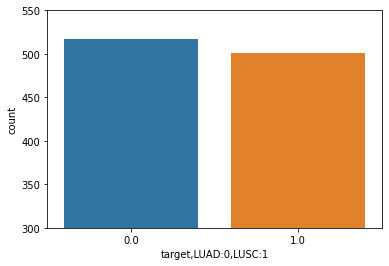

In [ ]:
sns.countplot(x=df_copy.columns[-1], data=df_copy)
plt.ylim(300, 550)
print(df_copy.iloc[:, -1].value_counts())

LUAD : Lung Adenocarcinoma

LUSC : Lung Squamous Cell Carcinoma

## 2-2. Distribution of Features

In [ ]:
df_eda = df_copy.iloc[:, :-1]

@interact
def dist_plot(columns=df_eda.columns):
    fig = plt.figure(figsize=(20, 8))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    sns.boxplot(data=df_eda[columns], orient='v', ax=ax1)
    sns.histplot(data=df_eda[columns], bins='auto', kde=True, ax=ax2)

interactive(children=(Dropdown(description='columns', options=('ENTREZ:100134869|HGNC:37440|UBE2Q2P2', 'ENTREZ…

대부분 유전자 단백질 발현량 값은 오른쪽으로 꼬리가 긴 분포를 나타냄

In [ ]:
df_log_eda = np.log1p(df_eda)

@interact
def dist_plot(columns=df_log_eda.columns):
    fig = plt.figure(figsize=(20, 8))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    sns.boxplot(data=df_log_eda[columns], orient='v', ax=ax1)
    sns.histplot(data=df_log_eda[columns], bins='auto', kde=True, ax=ax2)

interactive(children=(Dropdown(description='columns', options=('ENTREZ:100134869|HGNC:37440|UBE2Q2P2', 'ENTREZ…

로그 변환 후, 전체적으로 안정적인 형태의 분포를 나타냄

# 3. Preprocessing

In [ ]:
X = df_copy.iloc[:, :-1]
y = df_copy.iloc[:,  -1]

## 3-1. Cancer-Related Gene Selection

암 종류별로 관련된 유전자 정보를 나타내는 외부 데이터 활용

(출처 : https://www.gsea-msigdb.org/gsea/msigdb/collections.jsp)

In [ ]:
data = []
with open('c4.cgn.v7.2.entrez.gmt', 'r', encoding='utf-8-sig') as f_input:
    for line in f_input:
        data.append(list(line.strip().split('\t')))
        
cancer_gene = pd.DataFrame(data)
cancer_gene.index = np.array(cancer_gene[0])
cancer_gene.drop(columns=[0, 1], axis=1, inplace=True)
cancer_gene.columns = np.arange(len(cancer_gene.columns))
cancer_gene

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423
MORF_ATRX,109,22872,686,8425,7402,9896,362,8834,3191,27097,51141,8540,27257,5291,3360,23304,26048,5985,6767,6755,51585,10978,4487,9857,8292,3363,4158,91754,9063,267,23042,7692,4361,4580,783,23023,10650,8629,5509,84284,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
MORF_ATOX1,55744,22928,10987,475,1175,9917,9643,7009,9377,3281,79053,8896,821,5861,10430,3276,8985,10857,6576,8892,5713,5714,1201,6301,10490,51606,9296,10134,10540,23438,6902,5684,1476,5868,1781,23480,7381,6637,5437,5887,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
MORF_BCL2,109,6861,8425,7402,362,364,8834,3801,3351,1663,8540,11103,23237,1409,916,5291,3360,2155,26048,6755,1395,4487,8292,3363,4158,267,8851,230,122616,4650,9263,3779,116,2048,10650,8629,25830,15,8658,91775,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
MORF_BNIP1,5817,109,27302,4902,6276,3603,6861,8425,9896,1565,2901,362,3596,364,8834,2342,5502,6513,23456,5566,6508,3892,84148,26011,9522,11103,8879,9640,124152,5291,9197,6239,3360,3980,6258,90586,1571,25771,26048,1394,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
MORF_BAG5,81605,9798,10987,22827,10492,10664,821,8896,9529,3276,56910,84364,5713,9166,6166,3550,11100,1327,8930,23196,7073,5868,1936,6726,5887,7555,4738,9550,9167,6500,2029,8161,8815,3735,5692,7341,6856,10959,8766,1173,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GNF2_TTN,4606,7125,4604,4632,26287,7273,9499,7170,6588,2027,4619,4620,11155,58529,89,7135,7136,7140,1158,7138,4703,5837,487,6261,10324,844,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
GNF2_TYK2,5699,55573,9960,83440,2000,393,6778,10097,1794,55233,5062,1654,1105,10209,9208,397,2665,3059,79415,3071,79585,1655,4126,7297,10095,10914,11151,23196,55027,663,2870,51317,3936,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
GNF2_UBE2I,3190,5436,6143,3185,2547,5936,6138,51690,517,51637,27335,2058,5688,5757,3735,7756,10285,6613,51035,7322,6132,7307,8664,6434,10632,689,51504,8665,10657,51082,5725,7329,51386,2091,6428,5682,8409,6217,6208,1973,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
GNF2_VAV1,5699,26578,2000,63940,

https://www.gsea-msigdb.org/gsea/msigdb/genesets.jsp?collection=CGN 에서 검색 가능

index : 암과 직접적으로 연관된 유전자의 symbol 명칭을 나타냄

value : index의 유전자와 연관이 있는 유전자의 entrez 번호를 나타냄

In [ ]:
rel_gene = []

for i in range(len(cancer_gene)):
    symbol = cancer_gene.index[i].split('_')[1]
    rel_gene.append(symbol)

len(rel_gene)

427

암과 직접적으로 관련된 유전자 427개

In [ ]:
selected_rel = []

for i in range(len(X.columns)):
    symbol_name = X.columns[i].split('|')[-1]
    if symbol_name in rel_gene:
        selected_rel.append(X.columns[i])

len(selected_rel)

323

그 중에서 데이터에 있는 유전자는 323개

In [ ]:
X_cancer = X[selected_rel]
X_cancer.shape

(1018, 323)

19,977 개의 유전자 중에서 암과 직접적으로 관련된 323개의 유전자 정보만을 사용

## 3-2. Log Transformation

In [ ]:
X_log = np.log1p(X_cancer)

## 3-3. Scaling

In [ ]:
scaler = StandardScaler()
scale_fit = scaler.fit_transform(X_log, y)
X_scaled = pd.DataFrame(scale_fit, index=X_log.index, columns=X_log.columns)

## 3-4. Augmentation

augmentation은 CV에서 fold에 따라 결과가 달라지기 때문에 함수로 정의 후 학습 진행 과정에서 사용

In [ ]:
def augmentation(X_train, y_train, method, n, mul, state_seed=None):

    data = pd.concat([X_train, y_train], axis=1)
    df_aug = pd.DataFrame(columns=data.columns)

    """
    Arguments:
        method: augmentation 방법
                1: 반응변수가 값이 같은 sample n개를 추출하여 모든 값을 평균하여 augmentation sample 생성
                2: sample n개를 추출하여 설명변수 값은 평균, 반응변수 값은 최빈값으로 augmentation sample 생성
                3: sample 2개를 추출하여 모든 값을 평균하여 augmentation sample 생성 (반응변수: 0.0, 0.5, 1.0)
                4: sample n개를 추출하여 모든 값을 평균하여 augmentation sample 생성 (반응변수: 0.0, 1.0 제외)
        n: 추출할 sample의 수
        mul: augmentation set의 데이터 개수가 train set의 데이터 개수의 몇 배인지를 의미       
    """


    if method == 1:

        data_0 = data.loc[y_train == 0]
        data_1 = data.loc[y_train == 1]
        
        for i in range(len(data_0)*mul):
            sam = data_0.sample(n, random_state=i+state_seed*10000)
            gen = sam.mean(axis=0)
            df_aug.loc[f'aug_sample:LUAD{i+1}'] = gen.values

        for i in range(len(data_1)*mul):
            sam = data_1.sample(n, random_state=i+state_seed*10000)
            gen = sam.mean(axis=0)
            df_aug.loc[f'aug_sample:LUSC{i+1}'] = gen.values

    if method == 2:

        i = 0
        idx0 = 1
        idx1 = 1

        while len(df_aug) < len(data) * mul:

            sam = data.sample(n, random_state=i+state_seed*10000)
            gen = sam.mean(axis=0)
            val = gen[y_train.name]

            if val < 0.5:
                gen[y_train.name] = 0.0
                df_aug.loc[f'aug_sample:LUAD{idx0}'] = gen.values
                idx0 += 1

            elif val > 0.5:
                gen[y_train.name] = 1.0
                df_aug.loc[f'aug_sample:LUSC{idx1}'] = gen.values
                idx1 += 1

            i += 1

    if method == 3:

        data_0 = data.loc[y_train == 0]
        data_1 = data.loc[y_train == 1]
    
        for i in range(len(data)*mul):
            sam1 = data_0.sample(int(n/2), random_state=i+state_seed*10000)
            sam2 = data_1.sample(int(n/2), random_state=i+state_seed*10000)
            gen = np.mean(pd.concat([sam1, sam2]))
            df_aug.loc[f'aug_sample{i}'] = gen.values

    if method == 4:

        i = 0

        while len(df_aug) < len(data)*mul:

            sam = data.sample(n, random_state=i+state_seed*10000)
            gen = sam.mean(axis = 0)

            if (gen[y_train.name] > 0.0) and (gen[y_train.name] < 1.0):
                df_aug.loc[f'aug_sample{i}'] = gen.values
                
            i += 1

    X_aug = df_aug.iloc[:, :-1]
    y_aug = df_aug.iloc[:,  -1]

    return X_aug, y_aug

# 4. Performance Comparision

## 4-1. Base Machine Learning Model

In [ ]:
data = pd.concat([X_scaled, y], axis=1)
X_features = data.iloc[:, :-1]
y_target = data.iloc[:, -1]
results = pd.DataFrame()

In [ ]:
seed = 42
fold = 10
skf = StratifiedKFold(n_splits=fold, shuffle=True, random_state=seed)

In [ ]:
models = {
    'Logistic Regreesion': LogisticRegression(random_state=seed),
    'Random Forest': RandomForestClassifier(random_state=seed),
    'Bagging': BaggingClassifier(random_state=seed),
    'Support Vector Machine': SVC(probability=True, random_state=seed),
    'AdaBoost': AdaBoostClassifier(random_state=seed),
    'XGBoost': XGBClassifier(random_state=seed),
    'LightGBM': LGBMClassifier(random_state=seed),
}

In [ ]:
for fold, (train_idx, test_idx) in enumerate(skf.split(X_features, y_target), 1):
    print(f"{fold}-fold")

    for model_name, model in models.items():

        # train, test set split
        X_train = data.iloc[train_idx, :-1]
        y_train = data.iloc[train_idx,  -1]
        X_test = data.iloc[test_idx, :-1]
        y_test = data.iloc[test_idx,  -1]

        # training
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        print(f"{model_name}: {training_time}")

        # evaluation
        pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, pred)
        results.loc[model_name, fold] = accuracy

    print(" ")

results['mean'] = np.mean(results, axis=1)
results

1-fold
Logistic Regreesion: 0.10183930397033691
Random Forest: 1.136023998260498
Bagging: 1.9077394008636475
Support Vector Machine: 0.5385901927947998
AdaBoost: 1.9156389236450195
XGBoost: 2.083352565765381
LightGBM: 5.499115228652954
 
2-fold
Logistic Regreesion: 0.08923172950744629
Random Forest: 1.128326654434204
Bagging: 1.8580892086029053
Support Vector Machine: 0.5499992370605469
AdaBoost: 1.9023408889770508
XGBoost: 1.986541986465454
LightGBM: 5.621592283248901
 
3-fold
Logistic Regreesion: 0.08316493034362793
Random Forest: 1.1110889911651611
Bagging: 1.7406346797943115
Support Vector Machine: 0.5202324390411377
AdaBoost: 1.9060046672821045
XGBoost: 1.9961450099945068
LightGBM: 5.5630693435668945
 
4-fold
Logistic Regreesion: 0.08147883415222168
Random Forest: 1.1267859935760498
Bagging: 2.0402512550354004
Support Vector Machine: 0.5357081890106201
AdaBoost: 1.9001991748809814
XGBoost: 1.9966576099395752
LightGBM: 5.503875732421875
 
5-fold
Logistic Regreesion: 0.0830879211425

,1,2,3,4,5,6,7,8,9,10,mean
Logistic Regreesion,0.823529,0.901961,0.823529,0.813725,0.754902,0.803922,0.892157,0.833333,0.910891,0.851485,0.840944
Random Forest,0.892157,0.862745,0.813725,0.862745,0.794118,0.813725,0.931373,0.843137,0.910891,0.861386,0.858600
Bagging,0.872549,0.833333,0.843137,0.872549,0.774510,0.843137,0.882353,0.852941,0.861386,0.831683,0.846758
Support Vector Machine,0.892157,0.882353,0.813725,0.862745,0.813725,0.803922,0.941176,0.833333,0.900990,0.891089,0.863522
AdaBoost,0.862745,0.901961,0.813725,0.833333,0.794118,0.813725,0.892157,0.882353,0.900990,0.821782,0.851689
XGBoost,0.872549,0.911765,0.833333,0.882353,0.823529,0.823529,0.892157,0.852941,0.881188,0.881188,0.865453
LightGBM,0.872549,0.901961,0.833333,0.901961,0.813725,0.843137,0.921569,0.833333,0.881188,0.861386,0.866414


## 4-2. Neural Network Classifier

### model definition

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        torch.manual_seed(seed)
        self.fc1 = nn.Linear(X_features.shape[1], 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

### earlystopping

In [ ]:
if os.path.isdir('pt'):
    print("It's already set up!")
else:    
    os.mkdir('pt')
    print("Done.")

Done.


In [ ]:
class EarlyStopping:

    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""

    def __init__(self, patience=10, verbose=False, delta=0, name=None):

        """
        Arguments:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            default: 10
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            default: 0
            name (str): checkpoint 저장 이름
        """

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.name = name

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)

        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):

        """validation loss가 감소하면 모델 저장"""

        if self.verbose:
            print(f"validation loss decreased ({self.val_loss_min:.5f} -> {val_loss:.5f}). saving model")

        torch.save(model.state_dict(), f'pt/{self.name}_checkpoint{fold}.pt')
        self.val_loss_min = val_loss

### hyper-parameter

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
alpha = 0.1
batch = 30
val_size = 0.1
epochs = 1000
patience = 50

### without augmentation data (baseline)

training

In [ ]:
base_train_loss = pd.DataFrame()
base_val_loss = pd.DataFrame()
base_epoch_list = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_features, y_target), 1):

    print(f"{fold}-fold Early stopping")

    # train, validation set split
    X_train = data.iloc[train_idx, :-1]
    y_train = data.iloc[train_idx,  -1]
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, stratify=y_train, random_state=seed)

    # to tensor
    X_train = torch.FloatTensor(X_train.values)
    y_train = torch.LongTensor(y_train.values)
    X_val = torch.FloatTensor(X_val.values)
    y_val = torch.LongTensor(y_val.values)

    train = TensorDataset(X_train, y_train)
    val = TensorDataset(X_val, y_val)

    # model
    model = Net()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # training
    train_loader = DataLoader(train, batch_size=batch, shuffle=False)
    early_stopping = EarlyStopping(patience=patience, verbose=True, name='base')

    for epoch in range(1, epochs+1):

        train_loss = []

        for X_train, y_train in train_loader:

            optimizer.zero_grad()    
            output = model(X_train)
            loss = criterion(output, y_train) + alpha * (torch.norm(model.fc1.weight, p=2) + torch.norm(model.fc2.weight, p=2))
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        output = model(X_val)
        loss = criterion(output, y_val) + alpha * (torch.norm(model.fc1.weight, p=2) + torch.norm(model.fc2.weight, p=2))
        val_loss = loss.item()

        train_loss = np.average(train_loss)
        base_train_loss.loc[fold, epoch] = train_loss
        base_val_loss.loc[fold, epoch] = val_loss

        print(f"[{epoch}/{epochs}] train_loss: {train_loss:.5f} & val_loss: {val_loss:.5f}")

        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            base_epoch_list.append(epoch)
            print(" ")
            break

1-fold Early stopping
[1/1000] train_loss: 1.05833 & val_loss: 0.93765
validation loss decreased (inf -> 0.93765). saving model
[2/1000] train_loss: 0.84455 & val_loss: 0.85031
validation loss decreased (0.93765 -> 0.85031). saving model
[3/1000] train_loss: 0.74006 & val_loss: 0.78151
validation loss decreased (0.85031 -> 0.78151). saving model
[4/1000] train_loss: 0.66295 & val_loss: 0.73157
validation loss decreased (0.78151 -> 0.73157). saving model
[5/1000] train_loss: 0.60275 & val_loss: 0.69652
validation loss decreased (0.73157 -> 0.69652). saving model
[6/1000] train_loss: 0.55648 & val_loss: 0.67120
validation loss decreased (0.69652 -> 0.67120). saving model
[7/1000] train_loss: 0.52262 & val_loss: 0.65558
validation loss decreased (0.67120 -> 0.65558). saving model
[8/1000] train_loss: 0.49872 & val_loss: 0.64313
validation loss decreased (0.65558 -> 0.64313). saving model
[9/1000] train_loss: 0.48256 & val_loss: 0.63290
validation loss decreased (0.64313 -> 0.63290). savin

In [ ]:
@interact
def loss_plot(columns=range(1, fold+1)):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.subplots()

    train_plot = base_train_loss.loc[columns, :base_epoch_list[columns-1]].values
    val_plot = base_val_loss.loc[columns, :base_epoch_list[columns-1]].values
    ax.plot(range(1, len(train_plot)+1), train_plot, label='training loss')
    ax.plot(range(1, len(val_plot)+1), val_plot, label='validaation loss')

    minposs = np.argmin(val_plot)+1
    ax.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')

    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax.set_ylim(0.2, 1)
    ax.set_xlim(0, base_epoch_list[columns-1])
    ax.grid(True)
    ax.legend()

interactive(children=(Dropdown(description='columns', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1), Outpu…

evaluation

In [ ]:
for fold, (train_idx, test_idx) in enumerate(skf.split(X_features, y_target), 1):

    # train, test set split
    X_train = data.iloc[train_idx, :-1]
    y_train = data.iloc[train_idx,  -1]
    X_test = data.iloc[test_idx, :-1]
    y_test = data.iloc[test_idx,  -1]

    # to tensor
    X_train = torch.FloatTensor(X_train.values)
    y_train = torch.LongTensor(y_train.values)
    X_test = torch.FloatTensor(X_test.values)
    y_test = torch.LongTensor(y_test.values)

    train = TensorDataset(X_train, y_train)
    test = TensorDataset(X_test, y_test)

    # training model
    model = Net()
    model.load_state_dict(torch.load(f'base_checkpoint{fold}.pt'))
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # evaluation
    output = model(X_test)
    _, preds = torch.max(output, 1)
    accuracy = torch.sum(preds == y_test) / len(test)
    results.loc['Neural Network (baseline)', fold] = accuracy.detach().numpy()

results['mean'] = np.mean(results, axis = 1)
results

,1,2,3,4,5,6,7,8,9,10,mean
Logistic Regreesion,0.823529,0.901961,0.823529,0.813725,0.754902,0.803922,0.892157,0.833333,0.910891,0.851485,0.840944
Random Forest,0.892157,0.862745,0.813725,0.862745,0.794118,0.813725,0.931373,0.843137,0.910891,0.861386,0.858600
Bagging,0.872549,0.862745,0.843137,0.872549,0.784314,0.843137,0.901961,0.823529,0.881188,0.851485,0.853659
Support Vector Machine,0.892157,0.882353,0.813725,0.862745,0.813725,0.803922,0.941176,0.833333,0.900990,0.891089,0.863522
AdaBoost,0.862745,0.901961,0.813725,0.833333,0.794118,0.813725,0.892157,0.882353,0.900990,0.821782,0.851689
XGBoost,0.872549,0.911765,0.833333,0.882353,0.823529,0.823529,0.892157,0.852941,0.881188,0.881188,0.865453
LightGBM,0.872549,0.901961,0.833333,0.901961,0.813725,0.843137,0.921569,0.833333,0.881188,0.861386,0.866414
Neural Network (baseline),0.892157,0.911765,0.813725,0.862745,0.843137,0.823529,0.941176,0.833333,0.910891,0.900990,0.873345


### with augmentation data

augmentation method, sampling number, multiple number

In [ ]:
# best result
method = 2
n = 4
mul = 1

pre-training

In [ ]:
pre_train_loss = pd.DataFrame()
pre_val_loss = pd.DataFrame()
pre_epoch_list = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_features, y_target), 1):

    print(f"{fold}-fold Early stopping")

    # train, validation set split
    X_train = data.iloc[train_idx, :-1]
    y_train = data.iloc[train_idx,  -1]
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, stratify=y_train, random_state=seed)

    # augmentation
    X_aug, y_aug = augmentation(X_train, y_train, method, n, mul, state_seed=fold)

    # combine train set & augmentation set
    X_pre = pd.concat([X_train, X_aug])
    y_pre = y_train.append(y_aug)

    # pre-training set split
    X_pre[y_pre.name] = y_pre.values
    pre_data = X_pre.sample(frac=1, random_state=seed)
    X_pre = pre_data.iloc[:, :-1]
    y_pre = pre_data.iloc[:,  -1]

    # to tensor
    X_pre = torch.FloatTensor(X_pre.values)
    y_pre = torch.LongTensor(y_pre.values)
    X_val = torch.FloatTensor(X_val.values)
    y_val = torch.LongTensor(y_val.values)

    pre = TensorDataset(X_pre, y_pre)
    val = TensorDataset(X_val, y_val)

    # model
    model = Net()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # pre-training
    pre_loader = DataLoader(pre, batch_size=batch, shuffle=False)
    early_stopping = EarlyStopping(patience=patience, verbose=True, name='pre')

    for epoch in range(1, epochs+1):

        train_loss = []

        for X_pre, y_pre in pre_loader:

            optimizer.zero_grad()    
            output = model(X_pre)
            loss = criterion(output, y_pre) + alpha * (torch.norm(model.fc1.weight, p=2) + torch.norm(model.fc2.weight, p=2))
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        output = model(X_val)
        loss = criterion(output, y_val) + alpha * (torch.norm(model.fc1.weight, p=2) + torch.norm(model.fc2.weight, p=2))
        val_loss = loss.item()

        train_loss = np.average(train_loss)
        pre_train_loss.loc[fold, epoch] = train_loss
        pre_val_loss.loc[fold, epoch] = val_loss

        print(f"[{epoch}/{epochs}] pre_loss: {train_loss:.5f} & val_loss: {val_loss:.5f}")

        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            pre_epoch_list.append(epoch)
            print(" ")
            break

1-fold Early stopping
[1/1000] pre_loss: 0.97662 & val_loss: 0.86723
validation loss decreased (inf -> 0.86723). saving model
[2/1000] pre_loss: 0.72087 & val_loss: 0.73695
validation loss decreased (0.86723 -> 0.73695). saving model
[3/1000] pre_loss: 0.59836 & val_loss: 0.65238
validation loss decreased (0.73695 -> 0.65238). saving model
[4/1000] pre_loss: 0.53240 & val_loss: 0.60067
validation loss decreased (0.65238 -> 0.60067). saving model
[5/1000] pre_loss: 0.50310 & val_loss: 0.57453
validation loss decreased (0.60067 -> 0.57453). saving model
[6/1000] pre_loss: 0.49098 & val_loss: 0.56426
validation loss decreased (0.57453 -> 0.56426). saving model
[7/1000] pre_loss: 0.48546 & val_loss: 0.55722
validation loss decreased (0.56426 -> 0.55722). saving model
[8/1000] pre_loss: 0.48119 & val_loss: 0.55265
validation loss decreased (0.55722 -> 0.55265). saving model
[9/1000] pre_loss: 0.47789 & val_loss: 0.54978
validation loss decreased (0.55265 -> 0.54978). saving model
[10/1000] 

In [ ]:
@interact
def loss_plot(columns = range(1, fold+1)):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.subplots()

    train_plot = pre_train_loss.loc[columns, :pre_epoch_list[columns-1]].values
    val_plot = pre_val_loss.loc[columns, :pre_epoch_list[columns-1]].values
    ax.plot(range(1, len(train_plot)+1), train_plot, label='pre-training loss')
    ax.plot(range(1, len(val_plot)+1), val_plot, label='validation loss')

    minposs = np.argmin(val_plot)+1
    ax.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')

    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax.set_ylim(0.2, 1)
    ax.set_xlim(0, pre_epoch_list[columns-1])
    ax.grid(True)
    ax.legend()

interactive(children=(Dropdown(description='columns', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1), Outpu…

training

In [ ]:
main_train_loss = pd.DataFrame()
main_val_loss = pd.DataFrame()
main_epoch_list = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_features, y_target), 1):

    print(f"{fold}-fold Early stopping")

    # train, validation set split
    X_train = data.iloc[train_idx, :-1]
    y_train = data.iloc[train_idx,  -1]
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, stratify=y_train, random_state=seed)

    # to tensor
    X_train = torch.FloatTensor(X_train.values)
    y_train = torch.LongTensor(y_train.values)
    X_val = torch.FloatTensor(X_val.values)
    y_val = torch.LongTensor(y_val.values)

    train = TensorDataset(X_train, y_train)
    val = TensorDataset(X_val, y_val)

    # pre-training model
    model = Net()
    model.load_state_dict(torch.load(f'pre_checkpoint{fold}.pt'))
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # training
    train_loader = DataLoader(train, batch_size=batch, shuffle=False)
    early_stopping = EarlyStopping(patience=patience, verbose=True, name='main')

    for epoch in range(1, epochs+1):

        train_loss = []

        for X_train, y_train in train_loader:

            optimizer.zero_grad()    
            output = model(X_train)
            loss = criterion(output, y_train) + alpha * (torch.norm(model.fc1.weight, p=2) + torch.norm(model.fc2.weight, p=2))
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        output = model(X_val)
        loss = criterion(output, y_val) + alpha * (torch.norm(model.fc1.weight, p=2) + torch.norm(model.fc2.weight, p=2))
        val_loss = loss.item()

        train_loss = np.average(train_loss)
        main_train_loss.loc[fold, epoch] = train_loss
        main_val_loss.loc[fold, epoch] = val_loss

        print(f"[{epoch}/{epochs}] train_loss: {train_loss:.5f} & val_loss: {val_loss:.5f}")

        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            main_epoch_list.append(epoch)
            print(" ")
            break

1-fold Early stopping
[1/1000] train_loss: 0.45081 & val_loss: 0.56465
validation loss decreased (inf -> 0.56465). saving model
[2/1000] train_loss: 0.43451 & val_loss: 0.55805
validation loss decreased (0.56465 -> 0.55805). saving model
[3/1000] train_loss: 0.42590 & val_loss: 0.56084
EarlyStopping counter: 1 out of 50
[4/1000] train_loss: 0.42324 & val_loss: 0.56078
EarlyStopping counter: 2 out of 50
[5/1000] train_loss: 0.42418 & val_loss: 0.55980
EarlyStopping counter: 3 out of 50
[6/1000] train_loss: 0.42367 & val_loss: 0.56307
EarlyStopping counter: 4 out of 50
[7/1000] train_loss: 0.42319 & val_loss: 0.56247
EarlyStopping counter: 5 out of 50
[8/1000] train_loss: 0.42277 & val_loss: 0.56440
EarlyStopping counter: 6 out of 50
[9/1000] train_loss: 0.42268 & val_loss: 0.56310
EarlyStopping counter: 7 out of 50
[10/1000] train_loss: 0.42230 & val_loss: 0.56549
EarlyStopping counter: 8 out of 50
[11/1000] train_loss: 0.42227 & val_loss: 0.56673
EarlyStopping counter: 9 out of 50
[12/

In [ ]:
@interact
def loss_plot(columns=range(1, fold+1)):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.subplots()

    train_plot = main_train_loss.loc[columns, :main_epoch_list[columns-1]].values
    val_plot = main_val_loss.loc[columns, :main_epoch_list[columns-1]].values
    ax.plot(range(1, len(train_plot)+1), train_plot, label='training loss')
    ax.plot(range(1, len(val_plot)+1), val_plot, label='validation loss')

    minposs = np.argmin(val_plot)+1
    ax.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')

    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax.set_ylim(0.2, 1)
    ax.set_xlim(0, main_epoch_list[columns-1])
    ax.grid(True)
    ax.legend()

interactive(children=(Dropdown(description='columns', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1), Outpu…

evaluation

In [ ]:
for fold, (train_idx, test_idx) in enumerate(skf.split(X_features, y_target), 1):

    # train, test set split
    X_train = data.iloc[train_idx, :-1]
    y_train = data.iloc[train_idx,  -1]
    X_test = data.iloc[test_idx, :-1]
    y_test = data.iloc[test_idx,  -1]

    # to tensor
    X_train = torch.FloatTensor(X_train.values)
    y_train = torch.LongTensor(y_train.values)
    X_test = torch.FloatTensor(X_test.values)
    y_test = torch.LongTensor(y_test.values)

    train = TensorDataset(X_train, y_train)
    test = TensorDataset(X_test, y_test)

    # pre-training & training model
    model = Net()
    model.load_state_dict(torch.load(f'main_checkpoint{fold}.pt'))
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # evaluation
    output = model(X_test)
    _, preds = torch.max(output, 1)
    accuracy = torch.sum(preds == y_test) / len(test)
    results.loc[f'method:{method} / n:{n} / mul:{mul}', fold] = accuracy.detach().numpy()

results['mean'] = np.mean(results, axis=1)
results

,1,2,3,4,5,6,7,8,9,10,mean
Logistic Regreesion,0.823529,0.901961,0.823529,0.813725,0.754902,0.803922,0.892157,0.833333,0.910891,0.851485,0.840944
Random Forest,0.892157,0.862745,0.813725,0.862745,0.794118,0.813725,0.931373,0.843137,0.910891,0.861386,0.858600
Bagging,0.872549,0.862745,0.843137,0.872549,0.784314,0.843137,0.901961,0.823529,0.881188,0.851485,0.853659
Support Vector Machine,0.892157,0.882353,0.813725,0.862745,0.813725,0.803922,0.941176,0.833333,0.900990,0.891089,0.863522
AdaBoost,0.862745,0.901961,0.813725,0.833333,0.794118,0.813725,0.892157,0.882353,0.900990,0.821782,0.851689
XGBoost,0.872549,0.911765,0.833333,0.882353,0.823529,0.823529,0.892157,0.852941,0.881188,0.881188,0.865453
LightGBM,0.872549,0.901961,0.833333,0.901961,0.813725,0.843137,0.921569,0.833333,0.881188,0.861386,0.866414
Neural Network (baseline),0.892157,0.911765,0.813725,0.862745,0.843137,0.823529,0.941176,0.833333,0.910891,0.900990,0.873345
method:1 / n:2 / mul:1,0.892157,0.892157,0.794118,0.882353,0.862745,0.833333,0.921569,0.852941,0.920792,0.881188,0.873335
method:1 / n:2 / mul:2,0.892157,0.901961,0.794118,0.892157,0.843137,0.813725,0.911765,0.862745,0.920792,0.891089,0.872365


### save results

In [ ]:
results.to_pickle(f'results.pkl')

In [ ]:
results.sort_values(by='mean', ascending=False)

,1,2,3,4,5,6,7,8,9,10,mean
method:2 / n:4 / mul:1,0.901961,0.911765,0.803922,0.892157,0.862745,0.843137,0.941176,0.852941,0.920792,0.900990,0.883159
method:2 / n:4 / mul:2,0.882353,0.911765,0.823529,0.872549,0.862745,0.843137,0.941176,0.862745,0.920792,0.891089,0.881188
method:2 / n:3 / mul:2,0.901961,0.911765,0.794118,0.882353,0.862745,0.823529,0.941176,0.843137,0.920792,0.881188,0.876276
method:2 / n:5 / mul:2,0.901961,0.901961,0.794118,0.901961,0.862745,0.803922,0.941176,0.852941,0.920792,0.871287,0.875286
method:2 / n:4 / mul:3,0.882353,0.911765,0.803922,0.882353,0.852941,0.833333,0.941176,0.823529,0.920792,0.891089,0.874325
Neural Network (baseline),0.892157,0.911765,0.813725,0.862745,0.843137,0.823529,0.941176,0.833333,0.910891,0.900990,0.873345
method:1 / n:2 / mul:1,0.892157,0.892157,0.794118,0.882353,0.862745,0.833333,0.921569,0.852941,0.920792,0.881188,0.873335
method:3 / n:2 / mul:1,0.872549,0.901961,0.823529,0.872549,0.833333,0.813725,0.950980,0.833333,0.910891,0.910891,0.872374
method:1 / n:2 / mul:2,0.892157,0.901961,0.794118,0.892157,0.843137,0.813725,0.911765,0.862745,0.920792,0.891089,0.872365
method:2 / n:5 / mul:1,0.882353,0.911765,0.803922,0.872549,0.862745,0.833333,0.950980,0.833333,0.910891,0.861386,0.872326
